<a href="https://colab.research.google.com/github/Nikita-NA/Semantic_chunking/blob/main/Sarvam_AI_Task_Submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 1: Semantic Chunking of a YouTube Video**

Dive into extracting meaningful audio-text pairs from a specific video. Show us your skill in achieving precise segmentation and alignment!

**CHOOSING GPU OVER CPU:**

GPUs are better for parallel processing, making them significantly faster for tasks like deep learning and audio transcription compared to CPUs. The `!nvidia-smi` command checks GPU status, driver, memory usage, and current processes to ensure the GPU is being utilized effectively.

In [ ]:
!nvidia-smi

Sun Nov 17 12:47:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())

2.5.1+cu121
CUDA available: True


**INSTALLING THE NECESSARY LIBRARIES:**

In [ ]:
# Install necessary libraries
!pip install yt-dlp pydub openai-whisper pyAudioAnalysis gradio
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


**IMPORT THE NECESSARY LIBRARIES:**

---


1.yt-dlp:  
* Used for downloading videos from YouTube and various other platforms, as well as extracting audio streams. It offers enhanced features over similar tools, including support for more sites and better performance, without requiring complicated setups.

2.whisper:
*   This library is for OpenAI's Whisper model, an automatic speech recognition (ASR) model. In this context, it's used to transcribe the audio into text, which forms the basis for generating semantic chunks.

3.gradio:
* used for creating interactive user interfaces quickly, making it simpler for non-technical users to engage with machine learning models compared to more complex web frameworks.

4.os:
* This standard Python library provides functions to interact with the operating system, like accessing and managing files and directories. It may be used here to handle file paths for saving audio files and outputs generated during processing.

5.torch:
* Provides GPU acceleration for enabling fast training and inference of deep learning models like Whisper particularly for large datasets and complex computations.

6.AudioSegment:
* This class allows for various audio processing tasks, such as loading audio files, adjusting volume levels, and applying noise reduction or silence trimming, to enhance audio quality before transcription.

In [ ]:
import yt_dlp
import whisper
import gradio as gr
import os
import torch
from pydub import AudioSegment

**STEP 1: DOWNLOAD VIDEO AND EXTRACT AUDIO:**  

---

Download the video and separate the audio component.

**POTENTIAL QUESTIONS:**

**1. Why did you choose yt_dlp instead of other libraries like pytube?**

yt_dlp provides better support for YouTube's API changes and adaptive streaming, making it more reliable and feature-rich than pytube for extracting audio.

**2. Why is FFmpegExtractAudio used, and what does it do?**

FFmpegExtractAudio extracts audio from the video directly into the specified format (wav), simplifying the process by avoiding a separate conversion step.

**3. Why is the audio format set to .wav specifically?**

.wav is uncompressed, preserving audio quality, which improves transcription accuracy in speech-to-text models. Compressed formats like MP3 might introduce artifacts that could reduce transcription accuracy.

**4. What happens if the output_audio_path provided does not end in .wav?**

The function ensures the filename ends in .wav by adjusting the output_audio_path, ensuring consistent formatting for downstream tasks.

**EXPLANATION OF THE CODE:**

The `download_video_audio` function downloads audio from a YouTube video using `yt-dlp`, saving it in WAV format. It takes the YouTube URL (`youtube_url`) and an optional output path (`output_audio_path`, defaulting to `audio.wav`). The function sets options to download the best quality audio and uses FFmpeg to extract it as WAV at 192 kbps. It initializes a `yt_dlp.YoutubeDL` object with these settings and downloads the audio. After downloading, it ensures the file has a `.wav` extension and returns the path to the saved audio. If an error occurs during the download, it prints an error message and returns `None`.

In [ ]:
# Function to download video and extract audio

# takes the url of youtube video to download and the path
# where the extracted audio has to be saved (default is audio.wav) as parameters

def download_video_audio(youtube_url, output_audio_path='audio.wav'):

    # set the desired options for yt-dlp:

    ydl_opts = {
        'format': 'bestaudio/best',   # downloads the best quality audio
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',   # extracts only audio from video
            'preferredcodec': 'wav',       # audio format is set to wav
            'preferredquality': '192',     # audio quality (bitrate) is set to 192 kbps
        }],

        # Specify base name without extension (.wav is chosen based on the format set)

        'outtmpl': 'audio',

    }

    try:
        # yt_dlp handles all processing, including format conversion to wav.
        # Creates a YoutubeDL object with ydl_opts as options.
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:

            # downloads the audio from the specified YouTube URL.
            ydl.download([youtube_url])

        # to ensure correct extension - remove last 4 char from output_audio_path
        # so that any existing .wav extension is excluded and then append .wav
        downloaded_audio_path = f"{output_audio_path[:-4]}.wav"

        # The output filename is 'audio.wav' if we set the outtmpl to 'audio'
        print(f"Audio downloaded to {downloaded_audio_path}")

        return downloaded_audio_path

    except Exception as e:
        # Prints an error message if the download or conversion fails
        print(f"An error occurred: {e}")
        return None


**STEP 2: TRANSCRIPTION OF AUDIO:**


---


Utilize an open-source Speech-to-Text model to transcribe the audio. Provide an explanation of the chosen model and any techniques used to enhance the quality of the transcription.

**WHY CHOOSE OPENAI - WHISPER MODEL?**

• State-of-the-Art Performance: Utilizes deep learning for high accuracy in speech recognition handling diverse languages and dialects.

• Multilingual support: Promotes inclusivity and facilitates communication for non-English speaking users. This aligns with Sarvam AI's mission to make technology accessible to a broader audience.

• Noise robustness: Designed to handle variable audio quality, ensuring clarity and accuracy.

• Rich Features for Enhanced Usability: Offers features like timestamps and confidence scores for transcriptions.

• Ideal for creating interactive audio-visual content, educational tools, and accessibility services.

**TECHNIQUES USED TO ENHANCE THE QUALITY OF TRANSCRIPTION:**

* The `preprocess_audio` function normalizes audio volume for better speech recognition and reduces noise by removing silence below a certain threshold.

* The `transcribe_audio` function allows users to specify a  `model_size` parameter, choosing between "small," "medium," or "large" models for varying accuracy based on available resources., depending on available resources.

*   Utilizes an advanced ASR model trained on diverse datasets for improved accuracy across various accents and languages.
*   Leverages GPU support for faster processing, enabling quicker transcription of long audio files.




**EXPLANATION OF THE CODE:**

The code defines two functions, `preprocess_audio` and `transcribe_audio`, for preparing and transcribing an audio file using OpenAI's Whisper model. The `preprocess_audio` function loads the audio file, normalizes its volume, and applies basic noise reduction by removing silent parts below -40 dB that last for at least 500ms, then combines these segments and saves the processed audio. The `transcribe_audio` function first preprocesses the audio, checks for GPU availability (using CUDA if available, otherwise CPU), and loads the Whisper model with the specified size. It then transcribes the processed audio in the desired language, prints the transcribed text, and returns audio-text segment pairs for further use. This setup streamlines audio preprocessing and transcription, enhancing audio clarity and transcription accuracy.



In [ ]:
from pydub.silence import split_on_silence

def preprocess_audio(input_audio_path, output_audio_path='processed_audio.wav'):
    """
    Preprocess the audio file by normalizing the volume and applying basic noise reduction.
    Saves the processed audio to output_audio_path.
    """
    # Load audio file with pydub
    audio = AudioSegment.from_file(input_audio_path)

    # Normalize audio volume
    normalized_audio = audio.apply_gain(-audio.max_dBFS)

    # Basic noise reduction - removing silence below a certain threshold
    # Split on silence with a minimum silence length of 500ms and a threshold of -40 dB
    audio_chunks = split_on_silence(
        normalized_audio,
        min_silence_len=500,  # Silence duration threshold (500ms)
        silence_thresh=-40    # Silence volume threshold (in dB)
    )

    # Combine all chunks into one processed audio segment
    combined_audio = sum(audio_chunks[:])
    # Export the combined audio to the output path
    combined_audio.export(output_audio_path, format="wav")
    print(f"Audio preprocessed and saved to {output_audio_path}")

    return output_audio_path


def transcribe_audio(audio_path, model_size="base", language="en"):
    """
    Transcribe the given audio file with Whisper.
    Allows selecting different model sizes for improved accuracy if needed.
    """
    # Preprocess audio for noise reduction and normalization
    processed_audio_path = preprocess_audio(audio_path)

    # Check if a CUDA-capable GPU is available; if not, use CPU
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load Whisper model of specified version (default is "base")
    model = whisper.load_model(model_size).to(device)

    # Pass the processed audio path specifying the language of the audio
    # transcription_result - contains dictionary of transcribed text and relevant segment info
    transcription_result = model.transcribe(processed_audio_path, language=language)

    # Print the transcribed text
    transcribed_text = transcription_result['text']
    print("Transcribed Text:", transcribed_text)

    # Create audio-text pairs
    return create_audio_text_pairs(transcription_result['segments'])



**STEP 3: TIME - ALIGN TRANSCRIPT WITH AUDIO:**


---


Describe the methodology and steps for aligning the transcript with the audio.

**METHODOLOGY:**

The process of time alignment involves matching the transcribed text segments with their corresponding audio segments based on their timestamps. This ensures that the displayed text corresponds accurately to what is being spoken in the audio at any given moment.

**STEPS:**

* Input Preparation: Begin with a list of audio segments, each containing metadata including start time, end time, and the corresponding text.

* Initialization: Create an empty list to store aligned audio-text pairs and initialize a chunk ID counter to uniquely identify each pair.

* Iterate Through Segments: Loop through each segment to extract start time, end time, and text, calculating the chunk length.

* Chunk Length Management: If the chunk length exceeds 15 seconds, split it into smaller chunks of 15 seconds, updating start and end times, and appending each chunk's details to the output list.

* Finalize and Return: After processing, append any remaining audio segment (if applicable) to the output list and return the list of aligned audio-text pairs.


**STEP 4: SEMANTIC CHUNKING OF DATA:**


---


Slice the data into audio-text pairs, using both semantic information from the text and voice activity information from the audio, with each audio-chunk being less than 15s in length. Explain the logic used for semantic chunking and discuss the strengths and weaknesses of your approach.

**EXPLANATION OF THE CODE:**

The `create_audio_text_pairs` function takes a list of transcription segments and breaks them into meaningful audio-text pairs, ensuring each chunk is 15 seconds or less. It initializes an empty list (`sample_output_list`) to store the resulting audio-text pairs and iterates through each segment to extract its start time, end time, and text. If a segment's duration exceeds 15 seconds, the function splits it into smaller chunks of exactly 15 seconds by adjusting start and end times accordingly, adding each chunk to the list with a unique `chunk_id`. When a segment is less than or equal to 15 seconds, it’s added directly. The function ultimately returns a structured list of audio-text pairs, each with `chunk_id`, `chunk_length`, `text`, `start_time`, and `end_time` fields, making it ideal for further processing.

In [ ]:
# Create audio-text pairs with semantic chunking
def create_audio_text_pairs(segments):
    # Initialize an empty list to hold the output audio-text pairs
    sample_output_list = []
    # Initialize a counter for chunk IDs
    chunk_id = 1

    # Iterate over each segment in the input list
    for segment in segments:
        # Extract the start and end times of the segment
        start_time = segment['start']
        end_time = segment['end']
        # Get the text from the segment and remove any leading or trailing whitespace
        text = segment['text'].strip()

        # Calculate the length of the chunk
        chunk_length = end_time - start_time
        # Check if the chunk length exceeds 15 seconds
        if chunk_length > 15.0:
            # Split long chunks into smaller chunks of 15 seconds
            while chunk_length > 15.0:
                # Determine the new end time for the chunk
                new_end_time = start_time + 15.0
                # Append the chunk details to the output list
                sample_output_list.append({
                    "chunk_id": chunk_id,
                    "chunk_length": 15.0,
                    "text": text,
                    "start_time": start_time,
                    "end_time": new_end_time,
                })
                # Update start_time for the next chunk
                start_time = new_end_time
                # Increment the chunk ID for the next chunk
                chunk_id += 1
                # Recalculate the length of the remaining chunk
                chunk_length = end_time - start_time

        # Add the final chunk if it has a positive length
        if chunk_length > 0:
            sample_output_list.append({
                "chunk_id": chunk_id,
                "chunk_length": chunk_length,
                "text": text,
                "start_time": start_time,
                "end_time": end_time,
            })
            # Increment the chunk ID for the next iteration
            chunk_id += 1

    # Return the list of audio-text pairs
    return sample_output_list


**STRENGTHS:**


---


**Effective Time Alignment:**

The code ensures accurate time alignment between the audio segments and their corresponding text. By extracting and preserving start and end times, it maintains the synchronization necessary for tasks like subtitle generation and semantic analysis.

**Dynamic Chunking:**

The logic to split audio segments longer than 15 seconds into smaller chunks allows for flexibility. This dynamic approach helps manage long segments without losing important context, making it easier to process and analyze.

**Semantic Preservation:**

By using the text content to determine chunking, the approach maintains semantic integrity. The chunks contain meaningful segments of speech, which can enhance the quality of downstream applications like transcription accuracy or audio analysis.

**WEAKNESSES:**

---



**Handling Overlaps and Gaps:**

The code does not account for overlapping speech or gaps in the audio, which can occur in real-world recordings. This may result in missing context or incomplete information if segments are not adequately managed.

**Performance Limitations:**

For very large audio datasets, the method may become less efficient. The process of iterating through segments and creating multiple smaller chunks could lead to performance bottlenecks if not optimized.

# GENERALIZATION:
The approach for creating audio-text pairs is broadly applicable in speech recognition, subtitling, content analysis, and interactive applications, as it ensures time alignment and maintains semantic integrity.

**Potential Failure modes:**

Background Noise: Significant noise can hinder accurate transcription.

Overlapping Speech: Multiple speakers can lead to misalignment.

Variable Speech Rates: Rapid or slow speech may disrupt natural chunking.

**Adaptation Strategies for Other Languages:**

Language-Specific Models: Utilize models trained on specific languages for better accuracy.

Cultural Considerations: Adjust chunking based on cultural communication styles.

Dialect and Accent Training: Incorporate diverse dialects to improve recognition.


# [Bonus-1] Gradio-app Interface:

---


Wrap your code in a gradio-app which
takes in youtube link as input and displays the output in a text-box.

**Gradio Interface**

for user - friendly interfaces for ML models, enabling easy  interaction with the audio processing application.

**EXPLANATION OF THE CODE:**

This code sets up a Gradio interface for transcribing YouTube videos and segmenting the text semantically. The `gradio_interface` function takes a YouTube URL, downloads the audio, processes and transcribes it, and returns audio-text pairs. The Gradio interface (`iface`) specifies a text input for the YouTube URL and outputs the transcription as JSON, with the title "YouTube Video Transcription and Semantic Segmentation." Finally, `iface.launch(debug=False)` runs the app for user interaction.

In [ ]:
# Gradio interface for user interaction
def gradio_interface(youtube_url):
    print(f"Processing URL: {youtube_url}")
    audio_path = download_video_audio(youtube_url)
    print("Starting transcription...")
    audio_text_pairs = transcribe_audio(audio_path)
    return audio_text_pairs

iface = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Textbox(label="YouTube URL"),
    outputs="json",
    title="YouTube Video Transcription and Semantic Segmentation",
)

iface.launch(debug= True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6d192335a1daa67bf2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Processing URL: https://youtu.be/Sby1uJ_NFIY?si=DfNZpw96UPniajVE
[youtube] Extracting URL: https://youtu.be/Sby1uJ_NFIY?si=DfNZpw96UPniajVE
[youtube] Sby1uJ_NFIY: Downloading webpage
[youtube] Sby1uJ_NFIY: Downloading ios player API JSON
[youtube] Sby1uJ_NFIY: Downloading mweb player API JSON
[youtube] Sby1uJ_NFIY: Downloading m3u8 information
[info] Sby1uJ_NFIY: Downloading 1 format(s): 251
[download] Destination: audio
[download] 100% of   28.63MiB in 00:00:00 at 29.20MiB/s  
[ExtractAudio] Destination: audio.wav
Deleting original file audio (pass -k to keep)
Audio downloaded to audio.wav
Starting transcription...
Audio preprocessed and saved to processed_audio.wav


100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 94.4MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

Transcribed Text:  Congratulations to you Mr. Raghavan for that. Thank you so much for joining us. Over to you. Hi everybody. How are you? This is at all. Like a post lunch, a downer or something. Let's hear it. Are you guys awake? All right. Better be because you have a superstar guest here. You heard the $41 million. I didn't hear on it. So we're going to ask for about $40 million from him by the end of this conversation. But let's get started. I want to introduce Vivek and Pratius, his co-founder who's not here. We wanted to start with a playing a video of what OpenHatty does. I encourage all of you to go to the website, 7.AI and check it out. But let me start by introducing Vivek. Vivek is a dear friend and he is very, very modest. One of the most modest guys that I know. But his personal journey, Vivek, you've been, you've got a PhD from Carnegie Mellon. You've sat in the sold company to Magma. And Vivek and I moved back to India from, we were both in the valley on the same day ac

# [Bonus-2] Utilizing Ground-Truth Transcripts:

---


Propose a method to improve the quality of your transcript using a ground-truth transcript provided as a single text string. Explain your hypothesis for this approach. Note that code-snippet isn't required for this question.

### Method to Enhance Transcript Quality Using Ground-Truth Transcripts

1. **Align Segments**: Match audio segments with the corresponding parts of the ground-truth transcript based on timestamps.

2. **Compare Texts**: Analyze the generated transcript against the ground-truth text, identifying discrepancies like misrecognized, omitted, or extraneous words.

3. **Correct Errors**: Modify the generated transcript using the ground-truth text to fix errors, prioritizing changes that significantly impact clarity.

4. **Contextual Adjustments**: Ensure corrections maintain grammatical and semantic integrity using NLP techniques.

5. **Feedback Loop**: Establish a review process where corrected segments are refined by users, facilitating ongoing improvement.

### Hypothesis for the Approach

The hypothesis is that using a ground-truth transcript as a reference will enhance the accuracy of generated transcripts. By aligning and comparing segments, we can systematically correct errors, leading to a more coherent and reliable representation of the audio. This approach aims to bridge the gap between automated transcription and human-level accuracy, making the output more valuable for applications like subtitling and content analysis.

# **Task 2: Exploratory Data Analysis of New Testament Audio and Text**

Get your hands dirty with a deep dive into the audio and text from the New Testament in your mother tongue. We're looking for sharp insights that could revolutionize text-to-speech and speech-to-text technologies.

**STEP 1: WEB SCRAPING FROM "Faith Comes by Hearing":**


---


Systematically download the audio files and their corresponding textual content for each of the 260 chapters of the New Testament from the specified website.

**PART 1: DOWNLOAD AUDIO:**


---


The code begins by installing necessary libraries for audio and data processing, then mounts Google Drive to access files in a specific directory. It lists all files in this directory, filters out wav files, and sorts the remaining files based on the numbers following 'B' and the second underscore in each filename, ensuring logical order for processing. The sorted filenames are then stored in a Pandas DataFrame (`audio_df`), which provides a structured format for easy handling. Finally, the DataFrame index is reset for a clean structure, and the number of files is printed to verify the total count.





In [ ]:
# Installing and Importing Required Libraries
!pip install pydub librosa nltk matplotlib seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re

# List files in the directory
files = os.listdir('/content/drive/My Drive/TAMDPIN1DA/Tamil_tam_DPI_NT_Non-Drama')

# Filter out .wav files
files = [file for file in files if not file.endswith('.wav')]

# Sort files based on two parts of the filename: the number after 'B' and the number after the second underscore
files.sort(key=lambda x: (int(re.search(r'B(\d+)', x).group(1)), int(re.search(r'___(\d+)', x).group(1))))

# Display the first 30 sorted files
print(files[:30])


['B01___01_Matthew_____TAMDPIN1DA.mp3', 'B01___02_Matthew_____TAMDPIN1DA.mp3', 'B01___03_Matthew_____TAMDPIN1DA.mp3', 'B01___04_Matthew_____TAMDPIN1DA.mp3', 'B01___05_Matthew_____TAMDPIN1DA.mp3', 'B01___06_Matthew_____TAMDPIN1DA.mp3', 'B01___07_Matthew_____TAMDPIN1DA.mp3', 'B01___08_Matthew_____TAMDPIN1DA.mp3', 'B01___09_Matthew_____TAMDPIN1DA.mp3', 'B01___10_Matthew_____TAMDPIN1DA.mp3', 'B01___11_Matthew_____TAMDPIN1DA.mp3', 'B01___12_Matthew_____TAMDPIN1DA.mp3', 'B01___13_Matthew_____TAMDPIN1DA.mp3', 'B01___14_Matthew_____TAMDPIN1DA.mp3', 'B01___15_Matthew_____TAMDPIN1DA.mp3', 'B01___16_Matthew_____TAMDPIN1DA.mp3', 'B01___17_Matthew_____TAMDPIN1DA.mp3', 'B01___18_Matthew_____TAMDPIN1DA.mp3', 'B01___19_Matthew_____TAMDPIN1DA.mp3', 'B01___20_Matthew_____TAMDPIN1DA.mp3', 'B01___21_Matthew_____TAMDPIN1DA.mp3', 'B01___22_Matthew_____TAMDPIN1DA.mp3', 'B01___23_Matthew_____TAMDPIN1DA.mp3', 'B01___24_Matthew_____TAMDPIN1DA.mp3', 'B01___25_Matthew_____TAMDPIN1DA.mp3', 'B01___26_Matthew_____TA

In [ ]:
import os
import re
import pandas as pd

# Create a DataFrame to store the sorted audio filenames
audio_df = pd.DataFrame(files, columns=['Audio_File'])

# Display the first few rows of the dataframe to verify
print(audio_df.head())

# If you want to reset the index and store it properly (optional):
audio_df.reset_index(drop=True, inplace=True)

print(len(audio_df))

                            Audio_File
0  B01___01_Matthew_____TAMDPIN1DA.mp3
1  B01___02_Matthew_____TAMDPIN1DA.mp3
2  B01___03_Matthew_____TAMDPIN1DA.mp3
3  B01___04_Matthew_____TAMDPIN1DA.mp3
4  B01___05_Matthew_____TAMDPIN1DA.mp3
260


**PART 2: DOWNLOAD TEXTUAL CONTENT:**


---



**EXPLANATION OF THE CODE:**



*   The code systematically downloads and saves the text of each chapter from the New Testament into a single text file. It begins by defining a base URL and a dictionary of books with their respective chapter counts.

*   The dictionary is designed this way as it remains the same across all languages; only the language code in the URL changes.


*   For each book and chapter, the code constructs the chapter URL and sends a GET request to fetch the webpage.

*   Since direct text download isn't available, HTML parsing with BeautifulSoup is used to locate the text content within specified containers.

*   The code then writes each chapter’s content to a file (`bible_text_all_books.txt`), along with book and chapter headers, and separates chapters with divider lines.

*   To manage server load, there’s a 1-second delay between requests. This approach ensures each chapter’s text is stored sequentially in a single, structured text file for easy reference.

In [ ]:
import requests
from bs4 import BeautifulSoup
import time

# Define the base URL and books with their chapter ranges
base_url = 'https://live.bible.is/bible/TAMDPI'
books = {
    "MAT": 28, "MRK": 16, "LUK": 24, "JHN": 21, "ACT": 28, "ROM": 16,
    "1CO": 16, "2CO": 13, "GAL": 6, "EPH": 6, "PHP": 4, "COL": 4,
    "1TH": 5, "2TH": 3, "1TI": 6, "2TI": 4, "TIT": 3, "PHM": 1,
    "HEB": 13, "JAS": 5, "1PE": 5, "2PE": 3, "1JN": 5, "2JN": 1,
    "3JN": 1, "JUD": 1, "REV": 22
}

# Open a single file to save all chapters
with open("bible_text_all_books.txt", "w", encoding="utf-8") as file:
    # Loop through each book and its respective chapters
    for book, chapters in books.items():
        for chapter in range(1, chapters + 1):
            # Construct the URL for the current chapter
            chapter_url = f"{base_url}/{book}/{chapter}"

            # Fetch the page content
            response = requests.get(chapter_url)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')

                # Locate the text container for verses
                text_container = soup.find('div', class_='text-container audio-player-open')

                # Check if the text container exists
                if text_container:
                    chapter_container = text_container.find('div', class_='chapter justify')

                    # Check if the chapter container exists
                    if chapter_container:
                        # Write book and chapter heading
                        file.write(f"Book: {book}, Chapter: {chapter}\n")
                        file.write("=" * 40 + "\n")

                        # Extract and save each verse
                        verse_elements = chapter_container.find_all('span', class_='align-left')
                        for verse in verse_elements:
                            verse_text = verse.get_text().strip()
                            file.write(verse_text + '\n')

                        file.write("\n" + "=" * 40 + "\n\n")
                        print(f"Saved {book} Chapter {chapter}")
                else:
                    print(f"Text container not found for {book} Chapter {chapter}")
            else:
                print(f"Failed to retrieve {book} Chapter {chapter} (Status code: {response.status_code})")

            # Delay to avoid overwhelming the server
            time.sleep(1)

print("Bible text saved to bible_text_all_books.txt")


Saved MAT Chapter 1
Saved MAT Chapter 2
Saved MAT Chapter 3
Saved MAT Chapter 4
Saved MAT Chapter 5
Saved MAT Chapter 6
Saved MAT Chapter 7
Saved MAT Chapter 8
Saved MAT Chapter 9
Saved MAT Chapter 10
Saved MAT Chapter 11
Saved MAT Chapter 12
Saved MAT Chapter 13
Saved MAT Chapter 14
Saved MAT Chapter 15
Saved MAT Chapter 16
Saved MAT Chapter 17
Saved MAT Chapter 18
Saved MAT Chapter 19
Saved MAT Chapter 20
Saved MAT Chapter 21
Saved MAT Chapter 22
Saved MAT Chapter 23
Saved MAT Chapter 24
Saved MAT Chapter 25
Saved MAT Chapter 26
Saved MAT Chapter 27
Saved MAT Chapter 28
Saved MRK Chapter 1
Saved MRK Chapter 2
Saved MRK Chapter 3
Saved MRK Chapter 4
Saved MRK Chapter 5
Saved MRK Chapter 6
Saved MRK Chapter 7
Saved MRK Chapter 8
Saved MRK Chapter 9
Saved MRK Chapter 10
Saved MRK Chapter 11
Saved MRK Chapter 12
Saved MRK Chapter 13
Saved MRK Chapter 14
Saved MRK Chapter 15
Saved MRK Chapter 16
Saved LUK Chapter 1
Saved LUK Chapter 2
Saved LUK Chapter 3
Saved LUK Chapter 4
Saved LUK Chap

**EXPLANATION OF THE CODE:**



*  The code processes the previously saved Bible text file by organizing its contents into a structured DataFrame. It begins by reading the file (`bible_text_all_books.txt`) and checking if it contains text.

*   The text is split into lines, and a loop iterates through each line to separate chapters based on the "Book: XX, Chapter: X" pattern.

*  Chapter headers are identified to create a unique key (e.g., "MAT_01") for each chapter, while verse text lines are appended to a list. Numeric prefixes (verse numbers) are removed from each line using a regular expression.


*   After parsing, each chapter’s key and text content are stored in a dictionary (`text_dict`). This dictionary is converted into a DataFrame (`text_df`), where each row corresponds to a chapter. Finally, the DataFrame’s structure is verified, and the total number of chapters is printed to confirm successful processing.


In [ ]:
import os
from collections import defaultdict
import pandas as pd

# Define the path to the saved Bible text file
file_path = 'bible_text_all_books.txt'

# Function to read and process the Bible text file
def process_bible_text(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read().strip()  # Read and remove any extra whitespace

            if content:
                print("The file contains text.")

                # Split text into chapters by looking for the "Book: XX, Chapter: X" pattern
                chapter_split = content.split("\n")

                # Initialize variables to store chapter text and chapter key
                text_dict = defaultdict(list)
                current_chapter_key = None
                current_chapter_text = []

                for line in chapter_split:
                    line = line.strip()

                    # Filter out unwanted continuous lines like the ones with "="
                    if "=" in line or not line:
                        continue

                    # Check if the line is a chapter header (e.g., "Book: MAT, Chapter: 1")
                    if line.startswith("Book:"):
                        # If there is a current chapter, save it
                        if current_chapter_key:
                            text_dict[current_chapter_key] = "\n".join(current_chapter_text).strip()

                        # Extract chapter key (e.g., MAT01)
                        parts = line.split(", ")
                        if len(parts) > 1:
                            book_info = parts[0].replace("Book: ", "").strip()
                            chapter_num = parts[1].replace("Chapter: ", "").strip()
                            current_chapter_key = f"{book_info}_{chapter_num.zfill(2)}"
                            current_chapter_text = []  # Reset the text for the new chapter
                    else:
                        # Remove numeric prefixes like "1 ", "2 " from the text
                        line = re.sub(r'^\d+\s+', '', line)  # Regex to remove the prefix number and space

                        # Collect text for the current chapter
                        current_chapter_text.append(line)

                # After the loop ends, save the last chapter's text
                if current_chapter_key:
                    text_dict[current_chapter_key] = "\n".join(current_chapter_text).strip()

                # Convert the dictionary to a DataFrame
                text_df = pd.DataFrame([(key, text) for key, text in text_dict.items()], columns=['chapter_key', 'text_content'])

                # Print a sample to verify the structure
                print("Text Data Sample:")
                print(text_df.head())

                return text_df
            else:
                print("The file is empty.")
                return None
    except FileNotFoundError:
        print("The file was not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Process the Bible text file and create the DataFrame
text_df = process_bible_text(file_path)

# Verify the total number of chapters
if text_df is not None:
    print("Total number of chapters in text:", len(text_df))


The file contains text.
Text Data Sample:
  chapter_key                                       text_content
0      MAT_01  ஆபிரகாமின் மகனாகிய தாவீதின் குமாரனான இயேசுகிறி...
1      MAT_02  ஏரோது ராஜாவின் நாட்களில் யூதேயாவிலுள்ள பெத்லகே...
2      MAT_03  அந்த நாட்களிலே யோவான்ஸ்நானன் யூதேயாவின் வனாந்த...
3      MAT_04  அப்பொழுது இயேசு பிசாசினால் சோதிக்கப்படுவதற்கு ...
4      MAT_05  இயேசு திரளான மக்களைக் கண்டு மலையின்மேல் ஏறினார...
Total number of chapters in text: 260


**STEP 2: DATA PREPARATION:**


---


Organize the data by chapters, ensuring each audio file is matched with its corresponding text.

**EXPLANATION OF THE CODE:**

This code combines the previously created audio and text data into a single DataFrame, allowing for easy access to both audio file paths and their corresponding text content. It begins by merging `audio_df` and `text_df` on their index, aligning each audio file with its respective chapter text. The merged DataFrame (`final_df`) includes columns for `Audio_File`, `chapter_key`, and `text_content`, facilitating a structured mapping between audio and text for each chapter. The code then verifies the merged DataFrame's structure by printing a sample and, if desired, saves it as a CSV file (`audio_text_mapping.csv`) for future use. Finally, it prints the total number of rows to confirm the data alignment.

In [ ]:
import os
import re
import pandas as pd


# Merge the DataFrames on the index directly
final_df = pd.concat([audio_df[['Audio_File']], text_df[['chapter_key', 'text_content']]], axis=1)

# Verify the merged DataFrame
print("Merged Data Sample:")
print(final_df.head())

# save this final DataFrame to a CSV for future use
final_df.to_csv('/content/drive/My Drive/TAMDPIN1DA/audio_text_mapping.csv', index=False)

# Verify the total number of rows in the final dataset
print(f'Total number of rows in final dataset: {len(final_df)}')


Merged Data Sample:
                            Audio_File chapter_key  \
0  B01___01_Matthew_____TAMDPIN1DA.mp3      MAT_01   
1  B01___02_Matthew_____TAMDPIN1DA.mp3      MAT_02   
2  B01___03_Matthew_____TAMDPIN1DA.mp3      MAT_03   
3  B01___04_Matthew_____TAMDPIN1DA.mp3      MAT_04   
4  B01___05_Matthew_____TAMDPIN1DA.mp3      MAT_05   

                                        text_content  
0  ஆபிரகாமின் மகனாகிய தாவீதின் குமாரனான இயேசுகிறி...  
1  ஏரோது ராஜாவின் நாட்களில் யூதேயாவிலுள்ள பெத்லகே...  
2  அந்த நாட்களிலே யோவான்ஸ்நானன் யூதேயாவின் வனாந்த...  
3  அப்பொழுது இயேசு பிசாசினால் சோதிக்கப்படுவதற்கு ...  
4  இயேசு திரளான மக்களைக் கண்டு மலையின்மேல் ஏறினார...  
Total number of rows in final dataset: 260


In [ ]:
# Print the column names to check for any unexpected ones
print(final_df.columns)

Index(['Audio_File', 'chapter_key', 'text_content'], dtype='object')


In [ ]:
print(final_df['text_content'].head(10))  # Preview the first 10 rows of text_content

0    ஆபிரகாமின் மகனாகிய தாவீதின் குமாரனான இயேசுகிறி...
1    ஏரோது ராஜாவின் நாட்களில் யூதேயாவிலுள்ள பெத்லகே...
2    அந்த நாட்களிலே யோவான்ஸ்நானன் யூதேயாவின் வனாந்த...
3    அப்பொழுது இயேசு பிசாசினால் சோதிக்கப்படுவதற்கு ...
4    இயேசு திரளான மக்களைக் கண்டு மலையின்மேல் ஏறினார...
5    “மனிதர்கள் காணவேண்டுமென்று அவர்களுக்கு முன்பாக...
6    நீங்கள் குற்றவாளிகளென்று தீர்க்கப்படாதபடிக்கு ...
7    இயேசு மலையிலிருந்து இறங்கினபோது, திரளான மக்கள்...
8    அப்பொழுது, அவர் படகில் ஏறி, இக்கரையில் உள்ள தம...
9    அப்பொழுது, இயேசு தம்முடைய பன்னிரண்டு சீடர்களைய...
Name: text_content, dtype: object


In [ ]:
final_df['text_content'] = final_df['text_content'].str.replace(r'^\d+\s+', '', regex=True)

# Print the cleaned DataFrame
final_df.head()

,Audio_File,chapter_key,text_content
0,B01___01_Matthew_____TAMDPIN1DA.mp3,MAT_01,ஆபிரகாமின் மகனாகிய தாவீதின் குமாரனான இயேசுகிறி...
1,B01___02_Matthew_____TAMDPIN1DA.mp3,MAT_02,ஏரோது ராஜாவின் நாட்களில் யூதேயாவிலுள்ள பெத்லகே...
2,B01___03_Matthew_____TAMDPIN1DA.mp3,MAT_03,அந்த நாட்களிலே யோவான்ஸ்நானன் யூதேயாவின் வனாந்த...
3,B01___04_Matthew_____TAMDPIN1DA.mp3,MAT_04,அப்பொழுது இயேசு பிசாசினால் சோதிக்கப்படுவதற்கு ...
4,B01___05_Matthew_____TAMDPIN1DA.mp3,MAT_05,இயேசு திரளான மக்களைக் கண்டு மலையின்மேல் ஏறினார...


**STEP 3: EXPLORATORY DATA ANALYSIS:**


---


Analyze the data to uncover patterns, anomalies, or insights that could benefit applications such as Text to Speech (TTS) and Speech to Text (STT) technologies. Your analysis should explore various facets of the data, including audio quality, text clarity, and alignment between text and spoken content.

**EXPLANATION OF THE CODE:**

This code initiates a basic exploratory data analysis (EDA) process to assess data quality in the merged DataFrame. It first checks for any missing values across columns in `final_df`, which is essential for identifying incomplete entries that might affect further analysis. The `.isnull().sum()` function provides a count of missing values per column, helping to pinpoint any gaps. Then, by displaying the first few rows with `print(final_df.head())`, the code offers an initial view of the data's structure and content, confirming that audio files are aligned with the appropriate text content for each chapter. This step ensures the dataset is clean and correctly formatted before additional analysis or processing.

In [ ]:
# Load and Preprocess Data

# Check if any missing values in the dataframe
print(final_df.isnull().sum())

# Verify the first few rows of data
print(final_df.head())


Audio_File      0
chapter_key     0
text_content    0
dtype: int64
                            Audio_File chapter_key  \
0  B01___01_Matthew_____TAMDPIN1DA.mp3      MAT_01   
1  B01___02_Matthew_____TAMDPIN1DA.mp3      MAT_02   
2  B01___03_Matthew_____TAMDPIN1DA.mp3      MAT_03   
3  B01___04_Matthew_____TAMDPIN1DA.mp3      MAT_04   
4  B01___05_Matthew_____TAMDPIN1DA.mp3      MAT_05   

                                        text_content  
0  ஆபிரகாமின் மகனாகிய தாவீதின் குமாரனான இயேசுகிறி...  
1  ஏரோது ராஜாவின் நாட்களில் யூதேயாவிலுள்ள பெத்லகே...  
2  அந்த நாட்களிலே யோவான்ஸ்நானன் யூதேயாவின் வனாந்த...  
3  அப்பொழுது இயேசு பிசாசினால் சோதிக்கப்படுவதற்கு ...  
4  இயேசு திரளான மக்களைக் கண்டு மலையின்மேல் ஏறினார...  


**EXPLANATION OF THE CODE:**

The code installs libraries and tools for audio processing:  
- **pydub** for manipulating audio files (conversion, slicing, etc.)  
- **eyed3** for handling audio metadata (e.g., MP3 tags)  
- **ffmpeg** for converting audio formats and handling multimedia files.

In [ ]:
!pip install pydub eyed3
!apt-get install ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 kB 22.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
from pydub.utils import mediainfo
import os
import eyed3

**EXPLANATION OF THE CODE:**

This function `extract_audio_features` extracts key features from an audio file:

- **File Size**: It uses `os.path.getsize()` to get the size of the audio file in bytes.
- **Duration**: It utilizes the `mediainfo` function (likely from the `ffmpeg` or `pydub` library) to get the duration of the audio file in seconds.
- **Sample Rate**: It retrieves the sample rate (in Hz) of the audio file using `audio_info['sample_rate']`.

These extracted features are returned in a dictionary for easy access and further analysis.

In [ ]:
def extract_audio_features(file_path):
    # Get file size
    file_size = os.path.getsize(file_path)  # In bytes

    # Using pydub to get the duration and sample rate
    audio_info = mediainfo(file_path)
    duration = float(audio_info['duration'])  # Duration in seconds
    sample_rate = int(audio_info['sample_rate'])  # Sample rate in Hz

    return {
        'File Size (bytes)': file_size,
        'Duration (seconds)': duration,
        'Sample Rate (Hz)': sample_rate
    }


**EXPLANATION OF THE CODE:**

This code extracts and stores audio file features, particularly file duration, for all `.mp3` files in a specified directory:

1. **Directory Specification**: The directory containing the audio files is specified (`/content/drive/My Drive/TAMDPIN1DA/Tamil_tam_DPI_NT_Non-Drama`).
2. **Iteration Over Files**: It loops through all the files, checking if the file ends with `.mp3`.
3. **Feature Extraction**: For each `.mp3` file, it calls the `extract_audio_features()` function (presumed to be defined earlier) to get the file's size, duration, and sample rate.
4. **Storing Data**: The file name and duration are appended to a list (`file_durations`).
5. **DataFrame Creation**: This list is then converted to a `pandas` DataFrame (`duration_df`) for easier viewing and saving.
6. **Saving Data**: The DataFrame is saved as a CSV file (`durations.csv`) for future use.


In [ ]:
import os
import pandas as pd

# Specify the directory where the files are located
directory = '/content/drive/My Drive/TAMDPIN1DA/Tamil_tam_DPI_NT_Non-Drama'

# List to store file names and their corresponding durations
file_durations = []

# Iterate through the sorted files
for file in files:
    if file.endswith('.mp3'):
        # Get the full path of the file
        file_path = os.path.join(directory, file)

        # Extract the features (assuming you have the extract_audio_features function)
        features = extract_audio_features(file_path)

        # Print or store the features
        print(f"File: {file}")
        print(f"File Size: {features['File Size (bytes)']} bytes")
        print(f"Duration: {features['Duration (seconds)']} seconds")
        print(f"Sample Rate: {features['Sample Rate (Hz)']} Hz")
        print('-' * 40)

        # Store the file name and duration in the list
        file_durations.append({
            'file_name': file,
            'duration_seconds': features['Duration (seconds)']
        })

# Convert the list of durations to a pandas DataFrame for easy viewing or saving
duration_df = pd.DataFrame(file_durations)

# save the DataFrame to a CSV file
duration_df.to_csv('/content/drive/My Drive/TAMDPIN1DA/durations.csv', index=False)

# Print the DataFrame (first few rows) to verify
print(duration_df.head())


File: B01___01_Matthew_____TAMDPIN1DA.mp3
File Size: 1855145 bytes
Duration: 230.512 seconds
Sample Rate: 24000 Hz
----------------------------------------
File: B01___02_Matthew_____TAMDPIN1DA.mp3
File Size: 2050985 bytes
Duration: 254.992 seconds
Sample Rate: 24000 Hz
----------------------------------------
File: B01___03_Matthew_____TAMDPIN1DA.mp3
File Size: 1529705 bytes
Duration: 189.832 seconds
Sample Rate: 24000 Hz
----------------------------------------
File: B01___04_Matthew_____TAMDPIN1DA.mp3
File Size: 2176361 bytes
Duration: 270.664 seconds
Sample Rate: 24000 Hz
----------------------------------------
File: B01___05_Matthew_____TAMDPIN1DA.mp3
File Size: 4004201 bytes
Duration: 499.144 seconds
Sample Rate: 24000 Hz
----------------------------------------
File: B01___06_Matthew_____TAMDPIN1DA.mp3
File Size: 3117545 bytes
Duration: 388.312 seconds
Sample Rate: 24000 Hz
----------------------------------------
File: B01___07_Matthew_____TAMDPIN1DA.mp3
File Size: 2407529 byt

**EXPLANATION OF THE CODE:**

This code merges the `final_df` DataFrame, which contains the audio-text mapping, with the `duration_df` DataFrame, which holds audio file durations:

1. **Merge Operation**: The `merged_df` is created by merging `final_df` with `duration_df` on the `Audio_File` and `file_name` columns. The merge is performed using a left join, meaning all rows from `final_df` will be retained, and matching rows from `duration_df` will be added based on the common file names.
   
2. **Drop Extra Column**: After the merge, the extra `file_name` column (from `duration_df`) is removed since it is no longer needed.

3. **Verification**: The first few rows of the merged DataFrame (`merged_df`) are printed to verify the merge.

4. **Save the Merged DataFrame**: The merged DataFrame is saved to a CSV file (`merged_df.csv`) for future use.

This approach integrates the audio file durations with the existing text data, providing a comprehensive dataset that combines both audio features and corresponding text content.

In [ ]:
# Merge final_df with duration_df on 'Audio_File' and 'file_name'
merged_df = pd.merge(final_df, duration_df, left_on='Audio_File', right_on='file_name', how='left')

# Drop the extra 'file_name' column that was added during the merge
merged_df = merged_df.drop(columns=['file_name'])

# Print the merged DataFrame (first few rows) to verify
print(merged_df.head())

# save the merged DataFrame to a CSV file
merged_df.to_csv('/content/drive/My Drive/TAMDPIN1DA/merged_df.csv', index=False)


                            Audio_File chapter_key  \
0  B01___01_Matthew_____TAMDPIN1DA.mp3      MAT_01   
1  B01___02_Matthew_____TAMDPIN1DA.mp3      MAT_02   
2  B01___03_Matthew_____TAMDPIN1DA.mp3      MAT_03   
3  B01___04_Matthew_____TAMDPIN1DA.mp3      MAT_04   
4  B01___05_Matthew_____TAMDPIN1DA.mp3      MAT_05   

                                        text_content  duration_seconds  
0  ஆபிரகாமின் மகனாகிய தாவீதின் குமாரனான இயேசுகிறி...           230.512  
1  ஏரோது ராஜாவின் நாட்களில் யூதேயாவிலுள்ள பெத்லகே...           254.992  
2  அந்த நாட்களிலே யோவான்ஸ்நானன் யூதேயாவின் வனாந்த...           189.832  
3  அப்பொழுது இயேசு பிசாசினால் சோதிக்கப்படுவதற்கு ...           270.664  
4  இயேசு திரளான மக்களைக் கண்டு மலையின்மேல் ஏறினார...           499.144  


In [ ]:
merged_df.head()

,Audio_File,chapter_key,text_content,duration_seconds
0,B01___01_Matthew_____TAMDPIN1DA.mp3,MAT_01,ஆபிரகாமின் மகனாகிய தாவீதின் குமாரனான இயேசுகிறி...,230.512
1,B01___02_Matthew_____TAMDPIN1DA.mp3,MAT_02,ஏரோது ராஜாவின் நாட்களில் யூதேயாவிலுள்ள பெத்லகே...,254.992
2,B01___03_Matthew_____TAMDPIN1DA.mp3,MAT_03,அந்த நாட்களிலே யோவான்ஸ்நானன் யூதேயாவின் வனாந்த...,189.832
3,B01___04_Matthew_____TAMDPIN1DA.mp3,MAT_04,அப்பொழுது இயேசு பிசாசினால் சோதிக்கப்படுவதற்கு ...,270.664
4,B01___05_Matthew_____TAMDPIN1DA.mp3,MAT_05,இயேசு திரளான மக்களைக் கண்டு மலையின்மேல் ஏறினார...,499.144


**EXPLANATION OF THE CODE:**

This code extracts audio features from `.mp3` files and saves the results to a CSV file:

1. **CSV File Creation**: A CSV file named `audio_features.csv` is created at the specified path (`/content/drive/My Drive/audio_features.csv`).

2. **Writing Header**: The first row written to the CSV contains column headers: `File Name`, `File Size (bytes)`, `Duration (seconds)`, and `Sample Rate (Hz)`.

3. **Extract Audio Features**: For each `.mp3` file in the specified directory, the function `extract_audio_features` is called to retrieve the file size, duration, and sample rate.

4. **Write File Data**: For each audio file, the relevant features (file name, size, duration, and sample rate) are written to the CSV file.

In [ ]:
import csv

# Define the CSV file to store the results
csv_file_path = '/content/drive/My Drive/audio_features.csv'

# Create and write to the CSV file
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write header row
    writer.writerow(['File Name', 'File Size (bytes)', 'Duration (seconds)', 'Sample Rate (Hz)'])

    # Write data for each file
    for file in files:
        if file.endswith('.mp3'):
            file_path = os.path.join(directory, file)
            features = extract_audio_features(file_path)

            # Write the row for this file
            writer.writerow([file, features['File Size (bytes)'], features['Duration (seconds)'], features['Sample Rate (Hz)']])

print(f"Audio features have been saved to {csv_file_path}")


Audio features have been saved to /content/drive/My Drive/audio_features.csv


**VISUALIZATIONS:**



---



**PLOT 1:** Audio Duration Distribution

This code generates a histogram to visualize the distribution of audio durations in the `.mp3` files within the specified directory:

1. **Extract Durations**: The code iterates over each `.mp3` file in the `files` list, extracting the duration using the `extract_audio_features` function and appending the durations to the `durations` list.

2. **Plot Histogram**: Using `matplotlib`, the histogram is created with:
   - **Bins**: 30 bins are used to categorize the durations.
   - **Color**: The bars are colored in `skyblue` with black edges for better visibility.
   - **Grid**: A grid is added for better readability of the plot.
   - **Labels**: The plot is labeled with a title ("Audio Duration Distribution"), and the x-axis represents the durations (in seconds), while the y-axis represents the frequency of those durations.

3. **Display**: The `plt.show()` function displays the plot, allowing you to visualize the distribution of audio durations in the dataset.


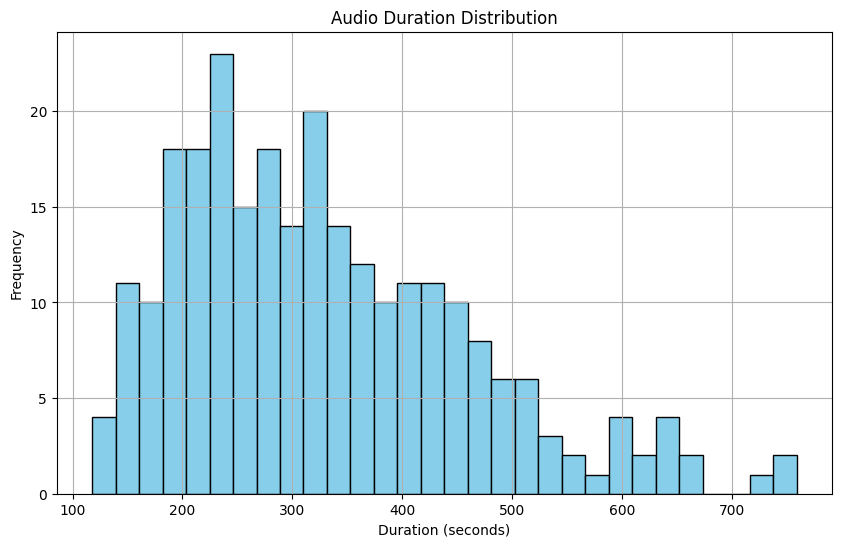

In [ ]:
import matplotlib.pyplot as plt

# List to store durations
durations = []

# Extracting duration for each file
for file in files:
    if file.endswith('.mp3'):
        file_path = os.path.join(directory, file)
        features = extract_audio_features(file_path)
        durations.append(features['Duration (seconds)'])

# Plotting the histogram for audio durations
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=30, color='skyblue', edgecolor='black')
plt.title('Audio Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


**EXPLANATION OF THE CODE:**

This code processes a Bible text file, extracting the content of each chapter and organizing it into a structured format for easy analysis.

1. **Reading the File**:
   - The code opens the `bible_text_all_books.txt` file in read mode with UTF-8 encoding. If the file is missing or there's an error during the reading process, an error message is displayed.

2. **Splitting the Text**:
   - The content of the file is read into a single string, which is then split into individual lines based on new lines (`\n`). This allows the program to process each line separately.

3. **Processing Each Line**:
   - Each line is examined to check if it is a chapter header (e.g., `Book: MAT, Chapter: 1`). If a line contains a chapter header, it forms a unique `chapter_key` by extracting the book and chapter numbers.
   - Non-header lines are considered part of the chapter’s content and are collected until the next chapter header is encountered.

4. **Storing Chapter Data**:
   - A dictionary (`text_dict`) is used to store each chapter's text, with the `chapter_key` as the key and the chapter’s text as the value. After all lines are processed, the text for the last chapter is saved.

5. **Creating and Returning a DataFrame**:
   - The dictionary is converted into a pandas DataFrame, where each row contains a `chapter_key` and its corresponding `text_content`.
   - The first few rows of the DataFrame are printed for verification. The function returns this DataFrame, which contains the structured chapter data. If any errors occur during the file reading or processing, `None` is returned.

In [ ]:
import os
from collections import defaultdict
import pandas as pd
import re
import matplotlib.pyplot as plt

# Define the path to the saved Bible text file
file_path = 'bible_text_all_books.txt'

# Function to read and process the Bible text file
def process_bible_text(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read().strip()  # Read and remove any extra whitespace

            if content:
                print("The file contains text.")

                # Split text into chapters by looking for the "Book: XX, Chapter: X" pattern
                chapter_split = content.split("\n")  # Split by new lines

                # Initialize variables to store chapter text and chapter key
                text_dict = defaultdict(list)
                current_chapter_key = None
                current_chapter_text = []

                for line in chapter_split:
                    line = line.strip()

                    # Check if the line is a chapter header (e.g., "Book: MAT, Chapter: 1")
                    if line.startswith("Book:"):
                        # If there is a current chapter, save it
                        if current_chapter_key:
                            text_dict[current_chapter_key] = "\n".join(current_chapter_text).strip()

                        # Extract chapter key (e.g., MAT01)
                        parts = line.split(", ")
                        if len(parts) > 1:
                            book_info = parts[0].replace("Book: ", "").strip()
                            chapter_num = parts[1].replace("Chapter: ", "").strip()
                            current_chapter_key = f"{book_info}_{chapter_num.zfill(2)}"
                            current_chapter_text = []  # Reset the text for the new chapter
                    else:
                        # Collect text for the current chapter
                        current_chapter_text.append(line)

                # After the loop ends, save the last chapter's text
                if current_chapter_key:
                    text_dict[current_chapter_key] = "\n".join(current_chapter_text).strip()

                # Convert the dictionary to a DataFrame
                text_df = pd.DataFrame([(key, text) for key, text in text_dict.items()], columns=['chapter_key', 'text_content'])

                # Print a sample to verify the structure
                print("Text Data Sample:")
                print(text_df.head())

                return text_df
            else:
                print("The file is empty.")
                return None
    except FileNotFoundError:
        print("The file was not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


**PLOT 2 :**   Word Count Distribution Across ChaptersAudio Duration Distribution

1. **Function Definition**:
   - The function `word_count_analysis` takes the `merged_df` DataFrame as input.
   - Inside this function, a helper function `count_words` is defined. This function uses a regular expression to tokenize the text (split it into words) and count the number of words. The text is converted to lowercase to ensure case insensitivity.

2. **Word Count Calculation**:
   - The `count_words` function is applied to the `text_content` column of `merged_df` using the `apply` method. This adds a new column, `word_count`, to the DataFrame, which stores the word count for each chapter.

3. **Visualization**:
   - A histogram is plotted using `matplotlib` to visualize the distribution of word counts across chapters. The `bins=30` argument creates 30 bins for the histogram, and the color is set to 'salmon', with black edges for each bin. The plot includes labels for the axes and a grid for better readability.

4. **Average Word Count**:
   - The average word count across all chapters is calculated using the `mean()` method and displayed in the console.





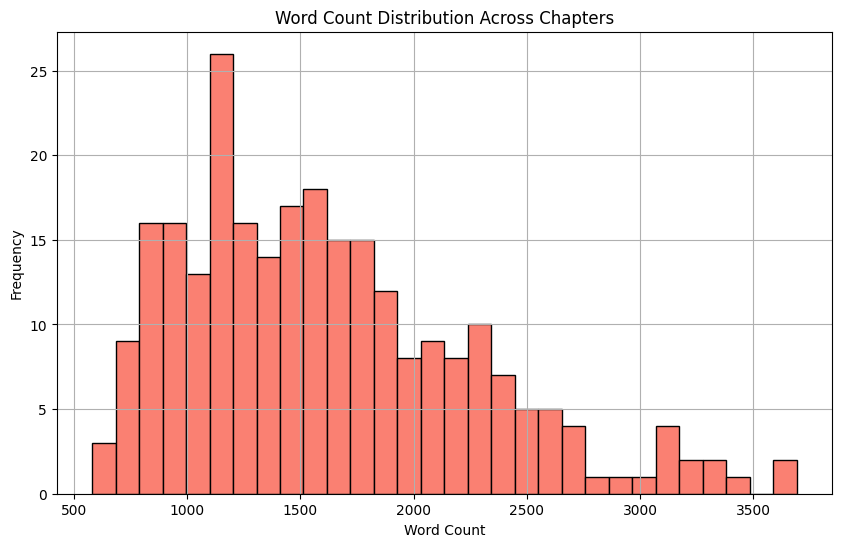

Average Word Count: 1615.38
  chapter_key  word_count
0      MAT_01        1137
1      MAT_02        1284
2      MAT_03         882
3      MAT_04        1242
4      MAT_05        2444
5      MAT_06        1876
6      MAT_07        1417
7      MAT_08        1617
8      MAT_09        1792
9      MAT_10        2043


In [ ]:
# Word Count Analysis
def word_count_analysis(merged_df):
    if merged_df is not None:
        # Define a function to count words in the text
        def count_words(text):
            words = re.findall(r'\b\w+\b', text.lower())  # Tokenize and convert to lowercase
            return len(words)

        # Apply the word count function to each row of the merged DataFrame
        merged_df['word_count'] = merged_df['text_content'].apply(count_words)

        # Display word count distribution
        plt.figure(figsize=(10, 6))
        plt.hist(merged_df['word_count'], bins=30, color='salmon', edgecolor='black')
        plt.title('Word Count Distribution Across Chapters')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

        # Print the average word count
        average_word_count = merged_df['word_count'].mean()
        print(f'Average Word Count: {average_word_count:.2f}')

        # Display the first 10 rows with their word count
        print(merged_df[['chapter_key', 'word_count']].head(10))

# Perform word count analysis on the merged DataFrame
word_count_analysis(merged_df)


In [ ]:
merged_df.head()

,Audio_File,chapter_key,text_content,duration_seconds,word_count
0,B01___01_Matthew_____TAMDPIN1DA.mp3,MAT_01,ஆபிரகாமின் மகனாகிய தாவீதின் குமாரனான இயேசுகிறி...,230.512,1137
1,B01___02_Matthew_____TAMDPIN1DA.mp3,MAT_02,ஏரோது ராஜாவின் நாட்களில் யூதேயாவிலுள்ள பெத்லகே...,254.992,1284
2,B01___03_Matthew_____TAMDPIN1DA.mp3,MAT_03,அந்த நாட்களிலே யோவான்ஸ்நானன் யூதேயாவின் வனாந்த...,189.832,882
3,B01___04_Matthew_____TAMDPIN1DA.mp3,MAT_04,அப்பொழுது இயேசு பிசாசினால் சோதிக்கப்படுவதற்கு ...,270.664,1242
4,B01___05_Matthew_____TAMDPIN1DA.mp3,MAT_05,இயேசு திரளான மக்களைக் கண்டு மலையின்மேல் ஏறினார...,499.144,2444


**PLOT 3 :** Text Length Distribution Across Chapters.


1. **Text Length Calculation**:
   - Inside the function `text_length_analysis`, another helper function `calculate_text_length` is defined to calculate the length of a chapter's text (in terms of the number of characters).
   - The `apply` method is used on the `text_content` column of the `merged_df` DataFrame, applying the `calculate_text_length` function to each row. This will create a new column `text_length` in the DataFrame, which stores the number of characters for each chapter.

2. **Visualization**:
   - A histogram is plotted using `matplotlib` to visualize the distribution of text lengths (number of characters) across all the chapters. The `bins=30` argument divides the data into 30 intervals, and the color of the bars is set to 'skyblue' with black edges for clarity.
   - The plot includes titles and axis labels for better interpretation and a grid for readability.

3. **Average Text Length**:
   - The average text length across all chapters is computed using the `mean()` method and displayed in the console.




The file contains text.
Text Data Sample:
  chapter_key                                       text_content
0      MAT_01  ========================================\n1 ஆப...
1      MAT_02  ========================================\n1 ஏர...
2      MAT_03  ========================================\n1 அந...
3      MAT_04  ========================================\n1 அப...
4      MAT_05  ========================================\n1 இய...


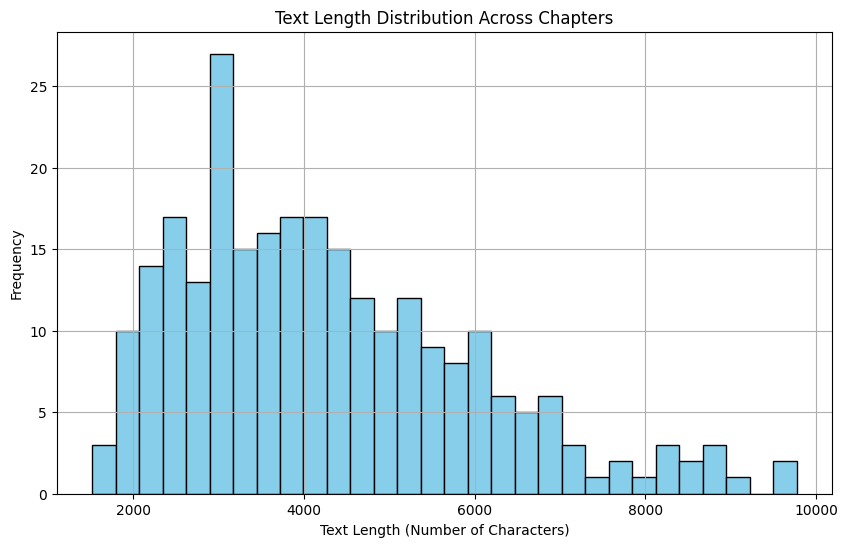

Average Text Length: 4265.75 characters
  chapter_key  text_length
0      MAT_01         2914
1      MAT_02         3357
2      MAT_03         2340
3      MAT_04         3286
4      MAT_05         6465
5      MAT_06         4958
6      MAT_07         3732
7      MAT_08         4397
8      MAT_09         4892
9      MAT_10         5454


In [ ]:
# Process the Bible text file and create the DataFrame
text_df = process_bible_text(file_path)

# Text Length Analysis
def text_length_analysis(merged_df):
    if merged_df is not None:
        # Define a function to calculate the text length (number of characters)
        def calculate_text_length(text):
            return len(text)

        # Apply the text length function to each row of the merged DataFrame
        merged_df['text_length'] = merged_df['text_content'].apply(calculate_text_length)

        # Display text length distribution
        plt.figure(figsize=(10, 6))
        plt.hist(merged_df['text_length'], bins=30, color='skyblue', edgecolor='black')
        plt.title('Text Length Distribution Across Chapters')
        plt.xlabel('Text Length (Number of Characters)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

        # Print the average text length
        average_text_length = merged_df['text_length'].mean()
        print(f'Average Text Length: {average_text_length:.2f} characters')

        # Display the first 10 rows with their text length
        print(merged_df[['chapter_key', 'text_length']].head(10))

# Perform text length analysis on the merged DataFrame
text_length_analysis(merged_df)


In [ ]:
merged_df.head()

,Audio_File,chapter_key,text_content,duration_seconds,word_count,text_length
0,B01___01_Matthew_____TAMDPIN1DA.mp3,MAT_01,ஆபிரகாமின் மகனாகிய தாவீதின் குமாரனான இயேசுகிறி...,230.512,1137,2914
1,B01___02_Matthew_____TAMDPIN1DA.mp3,MAT_02,ஏரோது ராஜாவின் நாட்களில் யூதேயாவிலுள்ள பெத்லகே...,254.992,1284,3357
2,B01___03_Matthew_____TAMDPIN1DA.mp3,MAT_03,அந்த நாட்களிலே யோவான்ஸ்நானன் யூதேயாவின் வனாந்த...,189.832,882,2340
3,B01___04_Matthew_____TAMDPIN1DA.mp3,MAT_04,அப்பொழுது இயேசு பிசாசினால் சோதிக்கப்படுவதற்கு ...,270.664,1242,3286
4,B01___05_Matthew_____TAMDPIN1DA.mp3,MAT_05,இயேசு திரளான மக்களைக் கண்டு மலையின்மேல் ஏறினார...,499.144,2444,6465


**PLOT 4 :** Word Cloud of Bible Text Content

**EXPLANATION OF THE CODE:**

1. **`wordcloud`**: This library is used to generate word clouds, which are a visual representation of the frequency of words in a text, where the size of each word is proportional to its frequency.
2. **`matplotlib`**: This library is commonly used for creating static, animated, and interactive visualizations in Python, including plots like histograms, line graphs, and scatter plots.

In [ ]:
!pip install wordcloud
!pip install matplotlib

**EXPLANATION OF THE CODE:**

1. **Function to Generate Word Cloud**:
   - The function `generate_word_cloud` takes a DataFrame `text_df` containing Bible text and combines all the chapter text into a single string using the `.join()` method.
   
2. **WordCloud Object**:
   - A `WordCloud` object is created with custom parameters:
     - `width` and `height` set the size of the word cloud image.
     - `background_color='white'` sets the background color of the word cloud.
     - `max_words=100` limits the number of words displayed in the cloud to 100.

3. **Display Word Cloud**:
   - The `wordcloud.generate()` function creates the word cloud image from the combined text.
   - `plt.imshow(wordcloud, interpolation='bilinear')` displays the word cloud as an image.
   - `plt.axis('off')` removes the axis lines for a cleaner look.
   - The title "Word Cloud of Bible Text Content" is displayed with the `plt.title()` method.


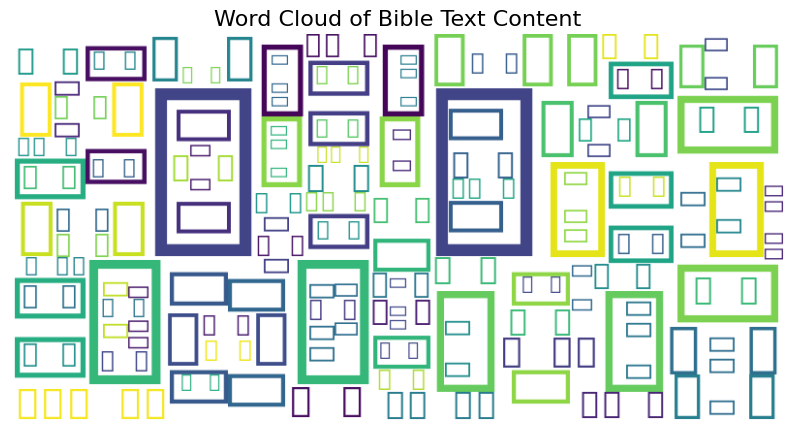

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate a Word Cloud from text content
def generate_word_cloud(text_df):
    # Combine all text content into a single string
    combined_text = " ".join(text_df['text_content'])

    # Create a WordCloud object with customizations (like background color and max words)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(combined_text)

    # Display the WordCloud image
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title('Word Cloud of Bible Text Content', fontsize=16)
    plt.show()

if text_df is not None:
    generate_word_cloud(text_df)


**VIEWING THE FINAL DATAFRAMES THAT ARE AVAILABLE FOR FURTHER PROCESS:**



In [ ]:
final_df.head()

,Audio_File,chapter_key,text_content
0,B01___01_Matthew_____TAMDPIN1DA.mp3,MAT_01,ஆபிரகாமின் மகனாகிய தாவீதின் குமாரனான இயேசுகிறி...
1,B01___02_Matthew_____TAMDPIN1DA.mp3,MAT_02,ஏரோது ராஜாவின் நாட்களில் யூதேயாவிலுள்ள பெத்லகே...
2,B01___03_Matthew_____TAMDPIN1DA.mp3,MAT_03,அந்த நாட்களிலே யோவான்ஸ்நானன் யூதேயாவின் வனாந்த...
3,B01___04_Matthew_____TAMDPIN1DA.mp3,MAT_04,அப்பொழுது இயேசு பிசாசினால் சோதிக்கப்படுவதற்கு ...
4,B01___05_Matthew_____TAMDPIN1DA.mp3,MAT_05,இயேசு திரளான மக்களைக் கண்டு மலையின்மேல் ஏறினார...


In [ ]:
merged_df.head()

,Audio_File,chapter_key,text_content,duration_seconds,word_count,text_length
0,B01___01_Matthew_____TAMDPIN1DA.mp3,MAT_01,ஆபிரகாமின் மகனாகிய தாவீதின் குமாரனான இயேசுகிறி...,230.512,1137,2914
1,B01___02_Matthew_____TAMDPIN1DA.mp3,MAT_02,ஏரோது ராஜாவின் நாட்களில் யூதேயாவிலுள்ள பெத்லகே...,254.992,1284,3357
2,B01___03_Matthew_____TAMDPIN1DA.mp3,MAT_03,அந்த நாட்களிலே யோவான்ஸ்நானன் யூதேயாவின் வனாந்த...,189.832,882,2340
3,B01___04_Matthew_____TAMDPIN1DA.mp3,MAT_04,அப்பொழுது இயேசு பிசாசினால் சோதிக்கப்படுவதற்கு ...,270.664,1242,3286
4,B01___05_Matthew_____TAMDPIN1DA.mp3,MAT_05,இயேசு திரளான மக்களைக் கண்டு மலையின்மேல் ஏறினார...,499.144,2444,6465


In [ ]:
audio_df

,Audio_File
0,B01___01_Matthew_____TAMDPIN1DA.mp3
1,B01___02_Matthew_____TAMDPIN1DA.mp3
2,B01___03_Matthew_____TAMDPIN1DA.mp3
3,B01___04_Matthew_____TAMDPIN1DA.mp3
4,B01___05_Matthew_____TAMDPIN1DA.mp3
...,...
255,B27___18_Revelation__TAMDPIN1DA.mp3
256,B27___19_Revelation__TAMDPIN1DA.mp3
257,B27___20_Revelation__TAMDPIN1DA.mp3
258,B27___21_Revelation__TAMDPIN1DA.mp3


In [ ]:
# Remove lines with "===" and leading digits (like "1") from text_content
text_df['text_content'] = text_df['text_content'].str.replace(r'={5,}', '', regex=True)  # Remove lines of "====="
text_df['text_content'] = text_df['text_content'].str.replace(r'^\d+\s?', '', regex=True).str.strip()  # Remove leading "1" or other digits

# Display the updated DataFrame
print(text_df.head())


  chapter_key                                       text_content
0      MAT_01  1 ஆபிரகாமின் மகனாகிய தாவீதின் குமாரனான இயேசுகி...
1      MAT_02  1 ஏரோது ராஜாவின் நாட்களில் யூதேயாவிலுள்ள பெத்ல...
2      MAT_03  1 அந்த நாட்களிலே யோவான்ஸ்நானன் யூதேயாவின் வனாந...
3      MAT_04  1 அப்பொழுது இயேசு பிசாசினால் சோதிக்கப்படுவதற்க...
4      MAT_05  1 இயேசு திரளான மக்களைக் கண்டு மலையின்மேல் ஏறின...


In [ ]:
duration_df

,file_name,duration_seconds
0,B01___01_Matthew_____TAMDPIN1DA.mp3,230.512
1,B01___02_Matthew_____TAMDPIN1DA.mp3,254.992
2,B01___03_Matthew_____TAMDPIN1DA.mp3,189.832
3,B01___04_Matthew_____TAMDPIN1DA.mp3,270.664
4,B01___05_Matthew_____TAMDPIN1DA.mp3,499.144
...,...,...
255,B27___18_Revelation__TAMDPIN1DA.mp3,329.128
256,B27___19_Revelation__TAMDPIN1DA.mp3,286.936
257,B27___20_Revelation__TAMDPIN1DA.mp3,208.912
258,B27___21_Revelation__TAMDPIN1DA.mp3,327.544


**Part 1: Audio Quality Analysis**


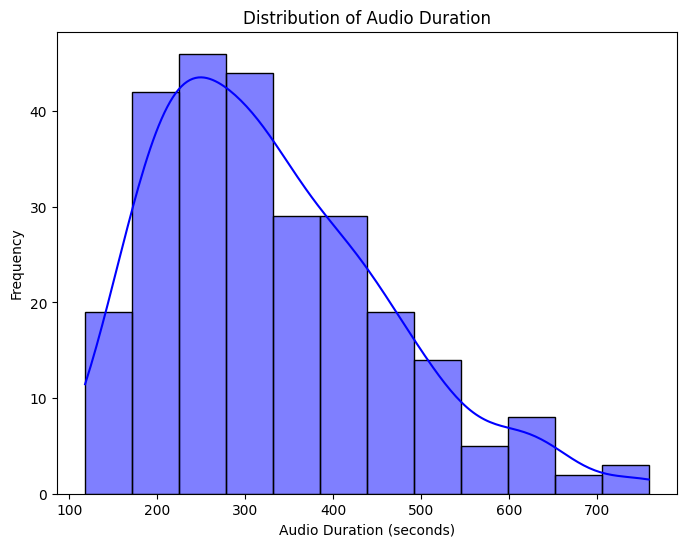

In [ ]:
import seaborn as sns

# Histogram: Audio Duration Distribution
plt.figure(figsize=(8, 6))
sns.histplot(merged_df['duration_seconds'], kde=True, color='blue')
plt.title('Distribution of Audio Duration')
plt.xlabel('Audio Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

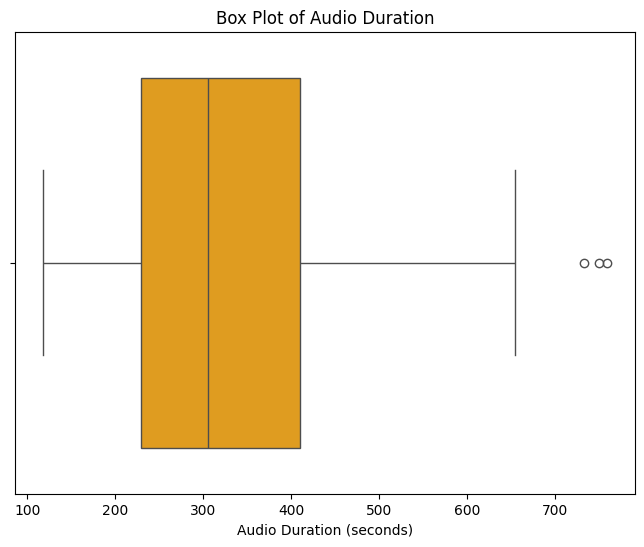

In [ ]:
# Box plot: Outliers in Audio Duration
plt.figure(figsize=(8, 6))
sns.boxplot(x=merged_df['duration_seconds'], color='orange')
plt.title('Box Plot of Audio Duration')
plt.xlabel('Audio Duration (seconds)')
plt.show()


**Part 2: Text Clarity Analysis**

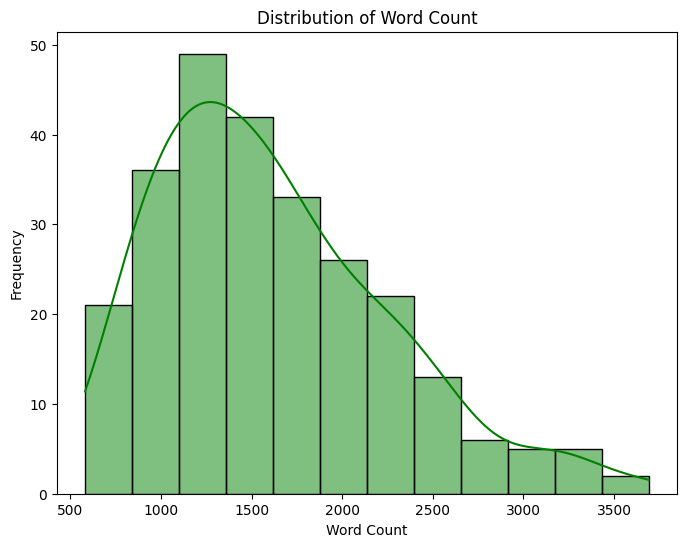

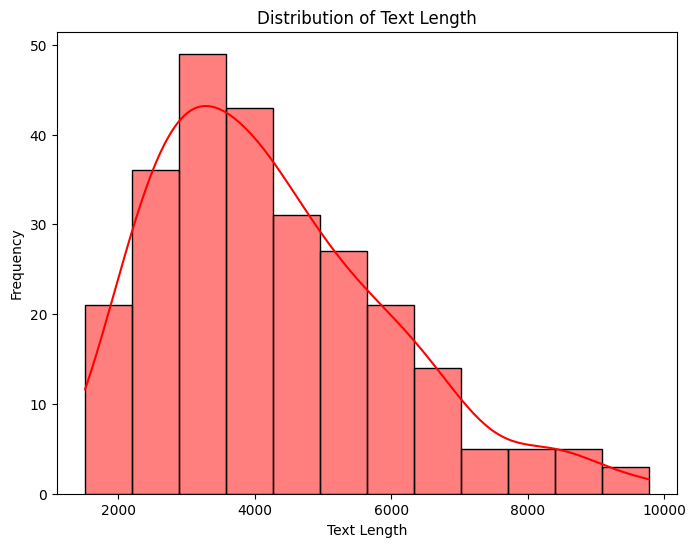

In [ ]:
# Histogram: Word Count Distribution
plt.figure(figsize=(8, 6))
sns.histplot(merged_df['word_count'], kde=True, color='green')
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Histogram: Text Length Distribution
plt.figure(figsize=(8, 6))
sns.histplot(merged_df['text_length'], kde=True, color='red')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

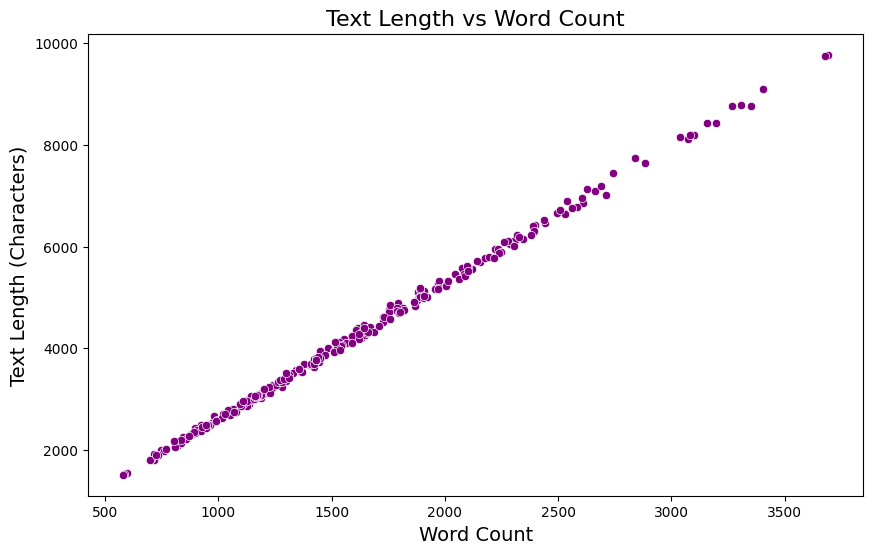

In [ ]:
# Scatter plot of Text Length vs Word Count
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_df['word_count'], y=merged_df['text_length'], color='purple')
plt.title('Text Length vs Word Count', fontsize=16)
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Text Length (Characters)', fontsize=14)
plt.show()


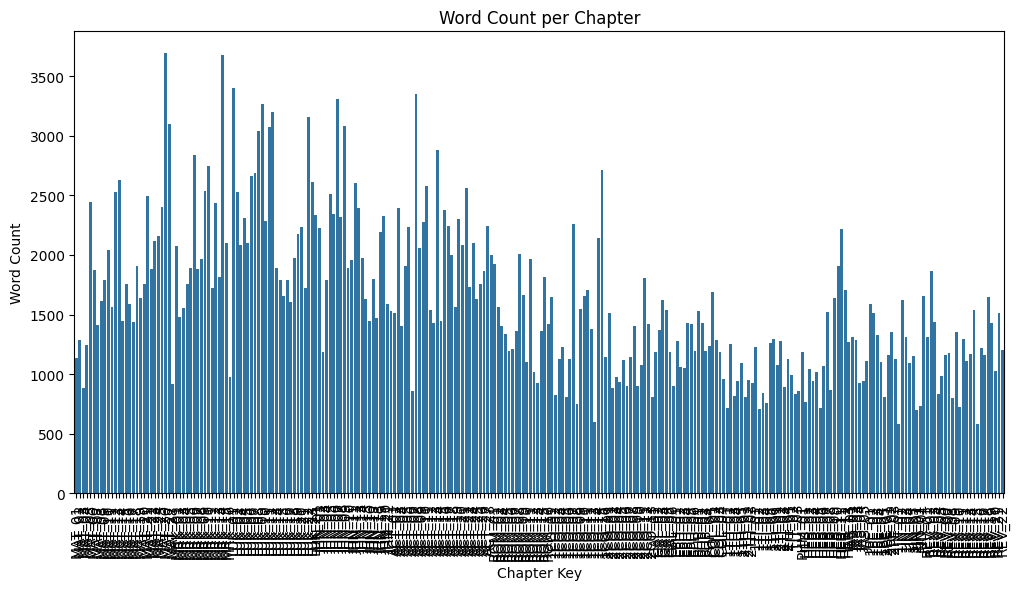

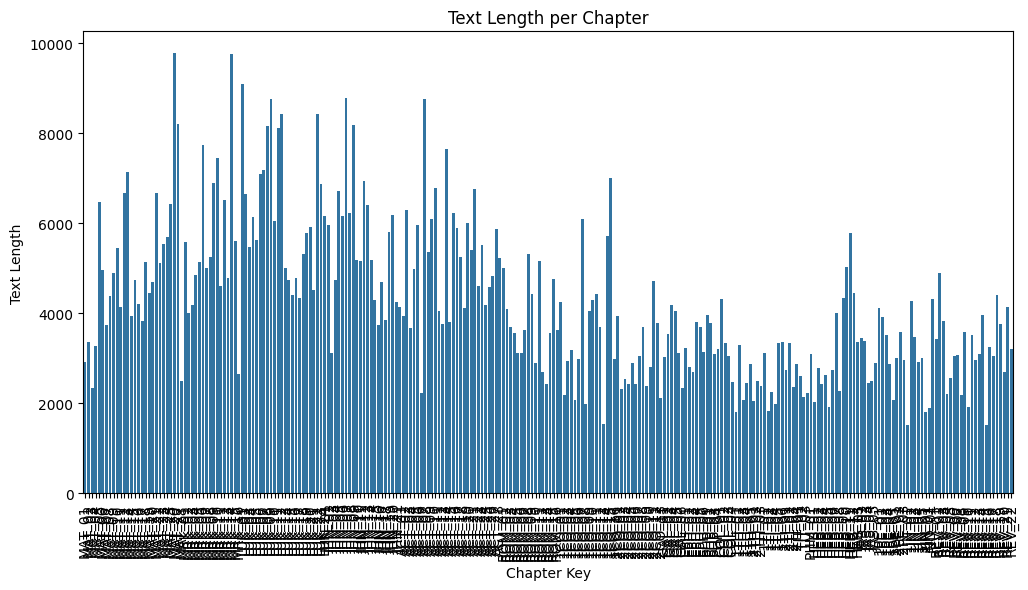

In [ ]:
# Word Count vs Chapter (Bar Plot)
plt.figure(figsize=(12, 6))
sns.barplot(x='chapter_key', y='word_count', data=merged_df)
plt.title('Word Count per Chapter')
plt.xlabel('Chapter Key')
plt.ylabel('Word Count')
plt.xticks(rotation=90)
plt.show()

# Text Length vs Chapter (Bar Plot)
plt.figure(figsize=(12, 6))
sns.barplot(x='chapter_key', y='text_length', data=merged_df)
plt.title('Text Length per Chapter')
plt.xlabel('Chapter Key')
plt.ylabel('Text Length')
plt.xticks(rotation=90)
plt.show()


**Part 3: Alignment Between Text and Spoken Content - CORRELATION ANALYSIS:**

Correlation between Audio Duration and Word Count:
                  duration_seconds  word_count
duration_seconds          1.000000    0.993352
word_count                0.993352    1.000000


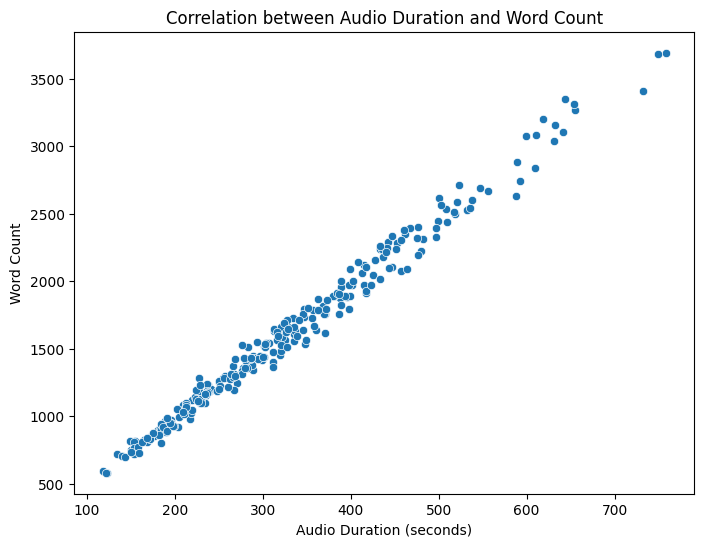

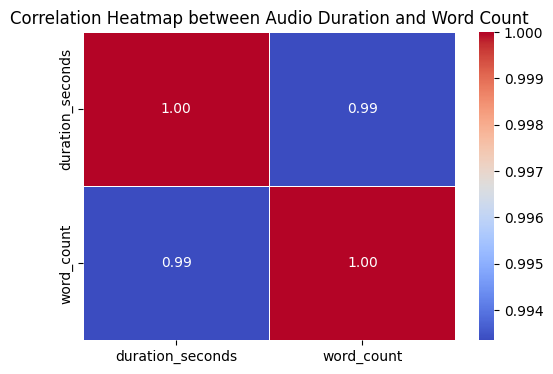

In [ ]:
# Correlation Between Audio Duration and Word Count

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation between 'duration_seconds' and 'word_count'
correlation = merged_df[['duration_seconds', 'word_count']].corr()

# Display the correlation matrix
print("Correlation between Audio Duration and Word Count:")
print(correlation)

# Visualize the correlation using a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='duration_seconds', y='word_count', data=merged_df)
plt.title('Correlation between Audio Duration and Word Count')
plt.xlabel('Audio Duration (seconds)')
plt.ylabel('Word Count')
plt.show()

# plot the correlation matrix using heatmap for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap between Audio Duration and Word Count')
plt.show()


Correlation between Audio Duration and Text Length:
                  duration_seconds  text_length
duration_seconds          1.000000     0.995287
text_length               0.995287     1.000000


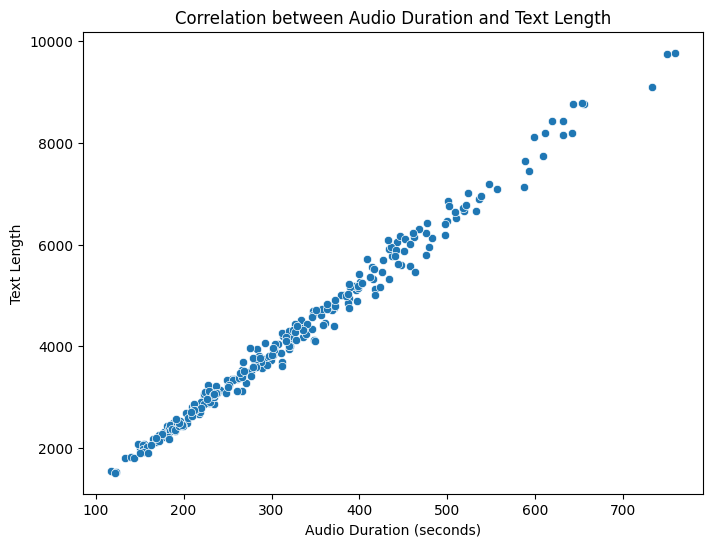

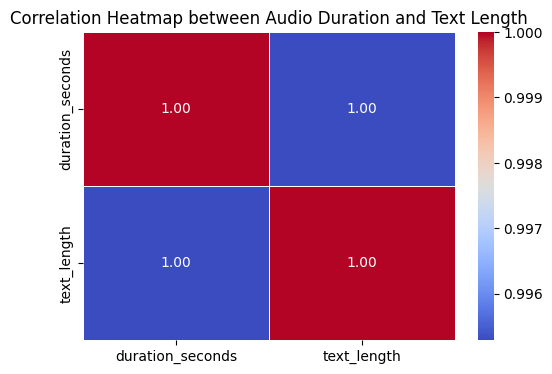

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate the correlation between 'duration_seconds' and 'text_length'
correlation_duration_text_length = merged_df[['duration_seconds', 'text_length']].corr()

# Display the correlation matrix
print("Correlation between Audio Duration and Text Length:")
print(correlation_duration_text_length)

# Visualize the correlation using a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='duration_seconds', y='text_length', data=merged_df)
plt.title('Correlation between Audio Duration and Text Length')
plt.xlabel('Audio Duration (seconds)')
plt.ylabel('Text Length')
plt.show()

# plot the correlation matrix using a heatmap for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_duration_text_length, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap between Audio Duration and Text Length')
plt.show()


### Key Performance Indicators (KPIs) and Methodological Explanation for TTS and STT Applications

#### 1. **Key Performance Indicators (KPIs)**

The analysis aimed at improving Text-to-Speech (TTS) and Speech-to-Text (STT) applications focused on key performance indicators relevant to the effectiveness of these technologies in real-world use cases. The following KPIs were analyzed:

- **Audio Duration Distribution**: Understanding the distribution of audio duration is essential for TTS and STT systems to handle input and output efficiently. The analysis highlighted that shorter durations were more common, but outliers with longer durations also exist, requiring systems to scale accordingly.
  
- **Word Count per Chapter (TTS Focus)**: For TTS applications, the word count per chapter was used as a proxy to understand the complexity of text input. Variations in word count directly impact speech synthesis, with longer texts posing greater challenges for maintaining speech fluidity and naturalness.
  
- **Text Length per Chapter (STT Focus)**: The text length of chapters processed through STT models can reveal potential challenges with speech recognition accuracy. A balance between text length and model training data is crucial for accurate transcription.

- **Word Cloud Insights (Text Content)**: The generated word cloud for Bible text highlighted common themes and terminology. This visualization helps to understand word frequency distributions and identify terms that TTS systems need to emphasize for clarity or to adjust pronunciation.

**Summary of Key Findings**:
- Audio duration tends to vary significantly, with a cluster of shorter durations and a few outliers.
- Word count and text length distributions suggest that both TTS and STT models must handle variations in text complexity efficiently.
- Visualizations such as word clouds can aid in optimizing TTS pronunciation and STT transcription accuracy by focusing on frequently used words.




#### 2. **Methodological Explanation**

**Data Collection**:
- **Web Scraping**: Direct text downloading from the Bible website was not available. As a result, a web scraping approach was implemented to collect Bible text data. This involved using Python's `requests` and `BeautifulSoup` libraries to scrape the text content from individual chapter pages. A key challenge in web scraping was handling inconsistent HTML structures, managing missing or incomplete data, and avoiding overloading the server with requests. To mitigate these issues, a delay mechanism (`time.sleep(1)`) was added to ensure the server was not overwhelmed, and error handling was applied to catch failed requests.

  For each chapter in the Bible, the scraper navigated to the relevant page, extracted verses, and saved the results in a structured format. The steps involved were:
  1. **Requests**: A request was made to the URL of each Bible chapter to fetch the page content.
  2. **Parsing HTML**: BeautifulSoup was used to parse the HTML content and locate the chapter text within the page.
  3. **Data Storage**: Once the text for each chapter was collected, it was saved into a single text file, organized by book and chapter.

  The challenge of directly downloading Bible text was overcome by dynamically scraping each chapter. This solution allowed for the extraction of relevant data in the absence of direct access to the full text in downloadable form.

**Exploratory Data Analysis (EDA)**:
- **Audio Data Processing**: The audio data, including durations and features, was processed using Python libraries such as `librosa` for feature extraction. The duration of audio files was analyzed to understand the range of values, which directly impacts TTS and STT models in real-time applications.
  
- **Text Data Processing**: The Bible text was processed using Python's `re` and `pandas` libraries to clean and structure the data. The text was split by chapters and words, and various analyses were performed, such as word count and text length. Challenges in this phase included handling large text files and ensuring correct chapter delimitations, which were solved by breaking the text into manageable chunks and using regular expressions for efficient processing.

**Challenges Faced**:
- **Handling Noise in Data**: Both audio and text data often contain noise (e.g., background noise in audio files, extraneous words in text). These were addressed by implementing noise reduction algorithms in audio processing and text cleaning techniques like removing unnecessary symbols.
  
- **Feature Extraction**: Extracting meaningful features from both audio and text required careful preprocessing. For instance, extracting audio features like duration, sample rate, and word counts in text required custom functions to ensure accurate data representation.

- **Using HTML Parsing in the Absence of API Access**: I would have used an API if I had access to it, but since I couldn’t get the API key, I used HTML parsing instead. A base URL and a dictionary of books with chapter counts were defined, consistent across languages with only the language code in the URL changing. For each book and chapter, a dynamic URL was constructed, and the HTML content was fetched using GET requests and parsed with BeautifulSoup to extract text.

#### 3. **Conclusion**

This analysis provides a comprehensive overview of the data that can inform the improvement of Text-to-Speech (TTS) and Speech-to-Text (STT) applications. By understanding audio duration, word count, text length, and frequently occurring words, we can better prepare these systems to handle real-world data, improving both accuracy and efficiency. The methodology outlined, including data preprocessing, feature extraction, and visualization, ensures that these insights are actionable and directly applicable to enhancing TTS and STT technologies.
